In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

In [2]:
# import torch
torch.cuda.empty_cache()

In [3]:
# from google.colab import files
# uploaded = files.upload()

In [4]:
# !unzip akshit_sum.zip

In [5]:
data1 = np.load('akshit_sum/data0.npy')
data2 = np.load('akshit_sum/data1.npy')
data3 = np.load('akshit_sum/data2.npy')
lab1 = np.load('akshit_sum/lab0.npy')
lab2 = np.load('akshit_sum/lab1.npy')
lab3 = np.load('akshit_sum/lab2.npy')

In [6]:
X = np.concatenate((data1,data2,data3))
Y = np.concatenate((lab1,lab2,lab3))
X = (X-0)/(255-0)
X = np.expand_dims(X, 1)      # if numpy array

train_x = X[:int(0.8*len(X))]
val_x = X[int(0.8*len(X)):]

train_y = Y[:int(0.8*len(Y))]
val_y = Y[int(0.8*len(Y)):]

train_x = torch.tensor(train_x)
val_x = torch.tensor(val_x)

train_y = torch.LongTensor(train_y)
val_y = torch.LongTensor(val_y)

In [7]:
X.shape

(30000, 1, 40, 168)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
class SumNet(torch.nn.Module):
    def __init__(self):
        super(SumNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1,2,5,1)
        self.conv2 = torch.nn.Conv2d(2,4,3,1)
        self.conv_bn_2 = torch.nn.BatchNorm2d(4)
        self.conv3 = torch.nn.Conv2d(4,8,3,1)
        self.conv4 = torch.nn.Conv2d(8,16,3,1)
        self.conv_bn_4 = torch.nn.BatchNorm2d(16)
        self.conv5 = torch.nn.Conv2d(16,32,3,1)
        self.conv6 = torch.nn.Conv2d(32,64,3,1)
        self.conv_bn_6 = torch.nn.BatchNorm2d(64)
        self.conv7 = torch.nn.Conv2d(64,64,3,1)
        self.conv8 = torch.nn.Conv2d(64,64,3,1)
        self.conv_bn_8 = torch.nn.BatchNorm2d(64)
        self.fc1 = torch.nn.Linear(1920, 512)
        self.fc2 = torch.nn.Linear(512, 64)
        self.fc3 = torch.nn.Linear(64, 37)



    def forward(self,x):
        x=self.conv1(x)
        x=torch.nn.functional.relu(x)
        x=self.conv2(x)
        x=torch.nn.functional.relu(x)
        x=torch.nn.functional.max_pool2d(x,kernel_size = [2,2],stride=[2,2])
        x = self.conv_bn_2(x)
        x=self.conv3(x)
        x=torch.nn.functional.relu(x)
        x=self.conv4(x)
        x=torch.nn.functional.relu(x)
        x=torch.nn.functional.max_pool2d(x,kernel_size = [1,2],stride=[1,2])
        x = self.conv_bn_4(x)
        x=self.conv5(x)
        x=torch.nn.functional.relu(x)
        x=self.conv6(x)
        x=torch.nn.functional.relu(x)
        x=torch.nn.functional.max_pool2d(x,kernel_size = [1,2],stride=[1,2])
        x = self.conv_bn_6(x)
        x=self.conv7(x)
        x=torch.nn.functional.relu(x)
        x=self.conv8(x)
        x=torch.nn.functional.relu(x)
        x=torch.nn.functional.max_pool2d(x,kernel_size = [1,2],stride=[1,2])
        x = self.conv_bn_8(x)
        x = torch.flatten(x, 1)
        # print("Size",x.shape)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        x = torch.nn.functional.relu(x)
        x = self.fc3(x)

        # output = F.log_softmax(x, dim=1)
        return x

In [10]:
model = SumNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',verbose=True,patience=100)
if torch.cuda.is_available():
    model = model.cuda()
    loss = loss.cuda()
    train_y = train_y.cuda()
    train_x = train_x.cuda()
    val_y = val_y.cuda()
    val_x = val_x.cuda()
print(model)

SumNet(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1))
  (conv_bn_2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv_bn_4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_bn_6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_bn_8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1920, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3):

In [11]:
index_list = np.arange(24000)
val_index_list = np.arange(6000)

train_losses= []
val_losses = []
batch_size = 64
cnt=-1
for epochs in range(20):
  random.shuffle(index_list)
  for batch_no in range(int(len(train_x)/batch_size)):
    cnt+=1
    # print(index_list[batch_size*batch_no:batch_size*(batch_no+1)])
    train_batch_x = train_x[index_list[batch_size*batch_no:batch_size*(batch_no+1)]] 
    train_batch_y = train_y[index_list[batch_size*batch_no:batch_size*(batch_no+1)]]

    output_train = model(train_batch_x.float())
    loss_train = loss(output_train, train_batch_y)
    train_losses.append(loss_train.item())
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if(cnt%1==0):
      random.shuffle(val_index_list)
      val_batch_x = val_x[val_index_list[:500]]
      val_batch_y = val_y[val_index_list[:500]]

      output_val = model(val_batch_x.float())
      loss_val = loss(output_val, val_batch_y)
      val_losses.append(loss_val.item())
      # scheduler.step(loss_val.item())
    else:
      val_losses.append(val_losses[-1])

  for param_group in optimizer.param_groups:
        lr = param_group['lr']

  if(lr<0.0000001):
    break

  print("Epoch #",epochs,"Completed")
  print(train_losses[-1],val_losses[-1])

Epoch # 0 Completed
3.2826106548309326 3.1705162525177
Epoch # 1 Completed
2.8136634826660156 2.9414448738098145
Epoch # 2 Completed
2.8684401512145996 2.7568254470825195
Epoch # 3 Completed
2.6076600551605225 2.6621475219726562
Epoch # 4 Completed
2.51680850982666 2.692072868347168
Epoch # 5 Completed
2.1983983516693115 2.74025297164917
Epoch # 6 Completed
1.8210651874542236 2.7449657917022705
Epoch # 7 Completed
1.688535213470459 2.888214349746704
Epoch # 8 Completed
1.7119868993759155 3.119389295578003
Epoch # 9 Completed
1.3994414806365967 3.2754697799682617
Epoch # 10 Completed
1.2581621408462524 3.570180892944336
Epoch # 11 Completed
1.067111849784851 3.885336399078369
Epoch # 12 Completed
0.7264870405197144 4.139591217041016
Epoch # 13 Completed
0.6629254817962646 4.5628581047058105
Epoch # 14 Completed
0.3550763428211212 5.253689765930176
Epoch # 15 Completed
0.30841800570487976 5.340494632720947
Epoch # 16 Completed
0.22658805549144745 5.630774974822998
Epoch # 17 Completed
0.

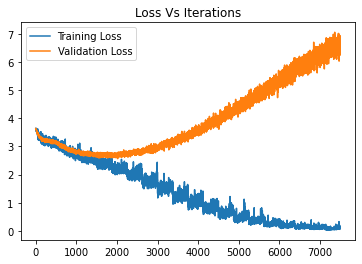

In [12]:
plt.plot(train_losses,label="Training Loss")
plt.plot(val_losses,label="Validation Loss")
plt.title("Loss Vs Iterations")
plt.legend()

In [13]:
# Accuracies

In [14]:
def get_accuracy(pred,y):
    accu_sum=0
    for i in range(len(y)):
        maxi=-100000
        maxind=-1
        for j in range(37):
          # print(pred[i][j])
          if pred[i][j] >= maxi:
              maxind = j
              maxi=pred[i][j]
        if(maxind==y[i]):
            accu_sum+=1
        
    return accu_sum

In [15]:
batch_size = 500
correct_preds=0
for batch_no in range(int(len(train_x)/batch_size)):
    train_batch_x = train_x[batch_size*batch_no:batch_size*(batch_no+1)] 
    train_batch_y = train_y[batch_size*batch_no:batch_size*(batch_no+1)]
    output_train = model(train_batch_x.float())
    correct_preds+=get_accuracy(output_train.cpu().detach().numpy(),train_batch_y.cpu().detach().numpy())
print("Overall Train Accuracy: ",100*correct_preds/len(train_x))

Overall Train Accuracy:  99.80833333333334


In [16]:
batch_size = 500
correct_preds=0
for batch_no in range(int(len(val_x)/batch_size)):
    val_batch_x = val_x[batch_size*batch_no:batch_size*(batch_no+1)] 
    val_batch_y = val_y[batch_size*batch_no:batch_size*(batch_no+1)]
    output_val = model(val_batch_x.float())
    correct_preds+=get_accuracy(output_val.cpu().detach().numpy(),val_batch_y.cpu().detach().numpy())
print("Overall Validation Accuracy: ",100*correct_preds/len(val_x))

Overall Validation Accuracy:  9.566666666666666


In [17]:
#saving and loading the model

In [18]:
torch.save(model,"SumNet_inital_model")

In [19]:
from google.colab import files
files.download('SumNet_inital_model') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
saved_model = torch.load("SumNet_inital_model")

In [24]:
saved_model.eval()

SumNet(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1))
  (conv_bn_2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv_bn_4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_bn_6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_bn_8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1920, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3):

In [29]:
batch_size = 500
correct_preds=0
for batch_no in range(int(len(train_x)/batch_size)):
    train_batch_x = train_x[batch_size*batch_no:batch_size*(batch_no+1)] 
    train_batch_y = train_y[batch_size*batch_no:batch_size*(batch_no+1)]
    output_train = saved_model(train_batch_x.float())
    correct_preds+=get_accuracy(output_train.cpu().detach().numpy(),train_batch_y.cpu().detach().numpy())
print("Overall Train Accuracy: ",100*correct_preds/len(train_x))

Overall Train Accuracy:  99.82916666666667


In [28]:
batch_size = 500
correct_preds=0
for batch_no in range(int(len(val_x)/batch_size)):
    val_batch_x = val_x[batch_size*batch_no:batch_size*(batch_no+1)] 
    val_batch_y = val_y[batch_size*batch_no:batch_size*(batch_no+1)]
    output_val = saved_model(val_batch_x.float())
    correct_preds+=get_accuracy(output_val.cpu().detach().numpy(),val_batch_y.cpu().detach().numpy())
print("Overall Validation Accuracy: ",100*correct_preds/len(val_x))

Overall Validation Accuracy:  9.733333333333333
